In [46]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

## input files

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in greater
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in less
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in less


0.7281756


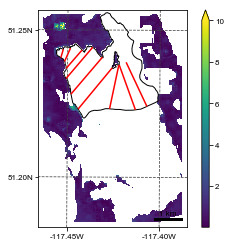

In [49]:
# season
balance = 'Ba'  # Bw or Ba (winter or annual)
# rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = 2018 # any of: 2016, 2017, 2018
I = np.abs(year - 2016) # for selecting raster inputs
vcorr=False ## is velocity corrected by off ice bias and stake bias?

gl = 2 # number to select glacier
Glacier = ['Kokanee', 'Conrad', 'Illecillewaet']
glacier = ['kokanee', 'conrad', 'illecillewaet']
d = 20. #20.  #distance (m) between flux gate points
Dint = 0.9 #depth integrated velocity ratio, 1.0= all sliding
sVZ = 4.91  #velocity against stake measurements
sHopt = 0.1 #10.3 ## ME:10.3 m,  MAE:0.223 (percent ratio)

fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[gl] + '/'

VDIR = 'individual'  # 'average' or 'individual'
if VDIR == 'individual':
#     vf_list = ['img1_20160912__img1_20170917_vmap_5m_35px_spm2/', 'img1_20160912__img1_20170917_vmap_5m_35px_spm2/',
#            'img1_20170521__img1_20180426_vmap_5m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/
    
    vf_list = ['img1_20160912__img1_20170521_vmap_5m_35px_spm2/', 'img1_20170521__img1_20180426_vmap_5m_35px_spm2/',
           'img1_20170917__img2_20181016_vmap_5m_35px_spm2/']
    #img1_20180426__img2_20181016_vmap_5m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/

#     vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/spm2/' + vf_list[I]
    vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/' + vf_list[I]
    VX = vdir+ vf_list[I][:-1] + '-F_vx.tif' 
    VY = vdir+ vf_list[I][:-1] + '-F_vy.tif' 
else:
#     vf_list = ['illec_all_spm2_5m', 'illec_all_spm2_5m', 'illec_all_spm2_5m']
#     vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/spm2/'  
#     VX = vdir+ 'vx/' +vf_list[I] + '_vx.tif' 
#     VY = vdir+ 'vy/' +vf_list[I] + '_vy.tif'
    vf = 'illecillewaet_all_dem3m'
    vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/'  
    VX = vdir + vf + '_vx_5m.tif' 
    VY = vdir + vf + '_vy_5m.tif'

topo = '/home/pelto/Desktop/lidar_cbt_analysis/illecillewaet/160912_illecillewaet_dem1_clip_master.tif'
farinotti = gpr_path + 'Illec/Illec_Geike_combi.tif' #''RGI60-02/RGI60-02.03688_thickness.tif' #'RGI60-02.00147_thickness_srtm_corr.tif' #'RGI60-02/RGI60-02.00147'

dhW_list = ['illecillewaet_2016_winter_dh_dt.tif', 'illecillewaet_2017_winter_dh_dt_dat1_clip.tif', 'illecillewaet_2018_winter_dh_dt_2.tif']
dhA_list = ['illecillewaet_2016_2015_dh_dt_clip.tif', 'illecillewaet_2017_2016_dh_dt.tif','illecillewaet_2018_2017_dh_dt_zmax1800.tif']
if balance == 'Bw':
    dh_r = path+ dhW_list[I]   #winter height change TIFF
else:
    dh_r = path+  dhA_list[I] #Annual height change TIFF

pts_file = fl_path + 'Illec_flux_gates_16_pts_20m.shp'  ##must be WGS84 currently
gates = fl_path+'Illec_flux_gates_16.shp'
shpf = '/home/pelto/GIS/outlines/Illec2016.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+'illec_flux_bins.shp'

obs = pd.read_csv(fl_path+ 'Illecillewaet_bdot.csv')
rho = pd.read_csv(fl_path + 'illec_rho.csv')  ## rho

# open GeoTIFF as array

vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
msk = salem.open_xr_dataset(path + 'illecillewaet_all_glaciers_2016.tif')#(fl_path + 'illec_all_glaciers_2016.tif') 
# msk = msk.to_array(name='msk')
gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'Illecillewaet101sw_MAE_optimized.tif') 
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(gates)

vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
# gpr = gpr.to_array(name='gpr')

# farin = farin.to_array(name='vx')
H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')
msk_reproj = vx.salem.transform(msk)
msk = msk_reproj.to_array(name='msk')

gpr_reproj = vx.salem.transform(gpr)
gpr = gpr_reproj.to_array(name='gpr')

farin_reproj= vx.salem.transform(farin)
farin = farin_reproj.to_array(name='farin')
srtm_corr = fl_path + 'illecillewaet_SRTM_diff_30m.tif'
srtm_corr = salem.open_xr_dataset(srtm_corr)
srtm_corr = vx.salem.transform(srtm_corr)
srtm_corr = srtm_corr.to_array(name='srtm_corr')
srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
srtm_corr.data[srtm_corr.data<-50.0] = 0.0 ##remove negative anomalous values
farin_corr = farin + srtm_corr
farin_corr= farin_corr.rename('farin_corr')

gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data<1.5] = 0.0   #not having any effect
VZ = np.sqrt(vx.data**2 + vy.data**2 )
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan

VZ_off_ice = VZ.copy()
VZ_off_ice[msk.data>0.0] = np.nan
VZ_off_ice[VZ_off_ice==0.0] = np.nan
# VZ_off_ice[VZ_off_ice>5.0] = np.nan

dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

#     # map extent
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(VZ_off_ice) #, label='m')
sm.set_vmax(val=10.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
off_ice_V = np.nanmean(VZ_off_ice)
print(off_ice_V)

gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.savefig(fl_path+ 'products/'+ glacier[gl] +'_thickness_gates.png', dpi=300)
plt.show()

## Functions for calculating zonal statistics over each flux gate bin

In [3]:
# https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
# For loading shapefiles into geopandas dataframe

def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)
 
def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
#     indices = input("Enter raster statistics selections separated by space: ")
    indices='2 3 5 6'
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats

## make an ice velocity quiver plot

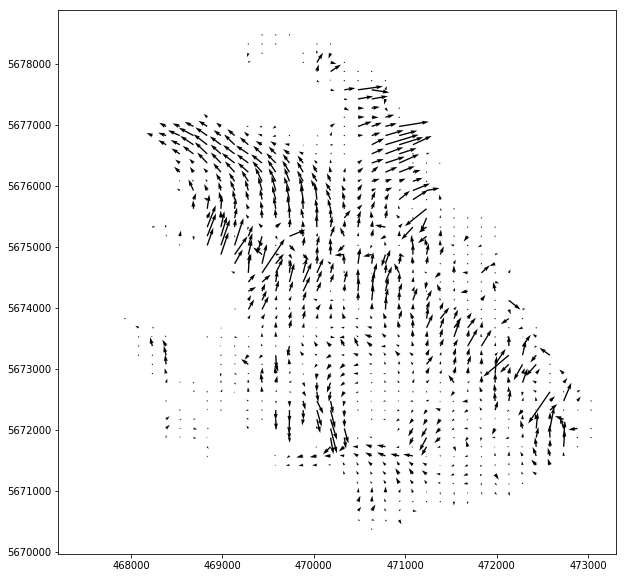

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

df = salem.read_shapefile(pts_file) 

df_file = loadshp_as_gpd(pts_file)
df_file.crs

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]

# ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

# shp_plt = reproject(df, VX)

X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
# ax.set_xlim(502500, 507500)
# ax.set_ylim( 5624000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ str(year)+'_quiver.pdf', dpi=300)

# grid.ij_coordinates
# v_crs = check_crs(vx)

In [5]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem',
       'farin_corr',
       #'msk',
       ]

In [6]:
M = xr.merge([vx,vy,gpr,H_opt,dem,farin_corr]) #dem

In [7]:
df[0:4]

,id,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y
0,4,1836.5,0.0,40.448468,POINT (-117.4481437497871 51.22812408699438),-117.448144,-117.448144,51.228124,51.228124,-117.448144,51.228124,468708.453948,5.675289e+06
1,4,1836.5,20.0,40.448468,POINT (-117.4479592583071 51.22826165279167),-117.447959,-117.447959,51.228262,51.228262,-117.447959,51.228262,468721.429225,5.675304e+06
2,4,1836.5,40.0,40.448468,POINT (-117.4477747657278 51.22839921829764),-117.447775,-117.447775,51.228399,51.228399,-117.447775,51.228399,468734.404503,5.675319e+06
3,4,1836.5,60.0,40.448468,POINT (-117.4475902720491 51.22853678351225),-117.447590,-117.447590,51.228537,51.228537,-117.447590,51.228537,468747.379780,5.675335e+06


In [8]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [9]:
df[0:4]

,id,len,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem,farin_corr
0,4,1836.5,0.0,40.448468,POINT (-117.4481437497871 51.22812408699438),-117.448144,-117.448144,51.228124,51.228124,-117.448144,51.228124,468708.453948,5.675289e+06,5.842867,11.371017,NaN,55.195427,2553.357192,46.377808
1,4,1836.5,20.0,40.448468,POINT (-117.4479592583071 51.22826165279167),-117.447959,-117.447959,51.228262,51.228262,-117.447959,51.228262,468721.429225,5.675304e+06,8.515638,14.199745,NaN,55.195427,2549.823877,43.595725
2,4,1836.5,40.0,40.448468,POINT (-117.4477747657278 51.22839921829764),-117.447775,-117.447775,51.228399,51.228399,-117.447775,51.228399,468734.404503,5.675319e+06,11.522799,18.429679,47.084651,67.173894,2544.928728,48.282623
3,4,1836.5,60.0,40.448468,POINT (-117.4475902720491 51.22853678351225),-117.447590,-117.447590,51.228537,51.228537,-117.447590,51.228537,468747.379780,5.675335e+06,11.854098,19.254819,49.376489,75.314514,2539.381514,45.516962


In [10]:
df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [11]:
# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))  

In [12]:
D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt', 'dem', 'farin_corr']].copy()
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,dem,farin_corr
ij,,,,,,,,,,,,
0169_0360,0,329.2,0.0,16.530925,-117.453702,51.240545,NaN,NaN,0.000000,6.393974,2070.360107,-8.014155
0170_0356,0,329.2,20.0,16.530925,-117.453622,51.240718,-16.082220,6.324901,23.226000,7.437881,2086.180908,-3.875984
0171_0353,0,329.2,40.0,16.530925,-117.453542,51.240890,-19.850935,10.724837,25.458000,7.437881,2091.899414,-0.963919
0172_0349,0,329.2,60.0,16.530925,-117.453463,51.241063,-19.400757,13.688827,27.818438,7.437881,2097.475342,8.442488
0174_0345,0,329.2,80.0,16.530925,-117.453383,51.241236,-20.368574,15.098462,32.694790,12.621210,2102.374756,9.960169
0175_0341,0,329.2,100.0,16.530925,-117.453303,51.241408,-21.620258,8.695881,34.441292,12.621210,2104.473877,13.195824
0176_0337,0,329.2,120.0,16.530925,-117.453223,51.241581,-28.467611,10.824115,35.254002,14.709440,2106.343018,15.871254
0177_0333,0,329.2,140.0,16.530925,-117.453143,51.241754,-19.526054,7.084815,35.477245,14.709440,2109.029297,19.599586
0178_0330,0,329.2,160.0,16.530925,-117.453063,51.241927,-19.060097,7.140527,35.133530,14.709440,2110.661377,19.599586


In [13]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
# D.vzdir[D.vzdir>25.0]=np.nan  ##remove outliers for Kokanee only!!

###this step for Illec only!!
D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone 


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.id==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.id==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt

KP=[]
KF=[]
for loop in D.index:
    ID= D[D.index==loop].id.values
    if ((ID==0) | (ID==1)):     
        KP.append( ((D[D.index==loop].vfg)* (Dint+0.1) * d * D.H_opt[D.index==loop]).values[0])  
        KF.append( ((D[D.index==loop].vfg)* (Dint+0.1) * d * D.farin_corr[D.index==loop]).values[0])
    else:
        KP.append((D[D.index==loop].vfg * Dint * d * D.H_opt[D.index==loop]).values[0])  ## ice flux per slice *0.9 to est. depth-integrated velocity
        KF.append((D[D.index==loop].vfg * Dint * d * D.farin_corr[D.index==loop]).values[0])
D['Qopt'] = KP
D['Qfarin'] = KF

# if vcorr==True:
#     D['Qopt'] = (D.vfg - off_ice_V + sVZ) * Dint * d * D.H_opt 
#     D['Qfarin'] = (D.vfg- off_ice_V+sVZ) * Dint * d * D.farin_corr 
#     ## ice flux per slice *0.9 to est. depth-integrated velocity
# else:
#     D['Qopt'] = (D.vfg) * Dint * d * D.H_opt 
#     D['Qfarin'] = (D.vfg) * Dint * d * D.farin_corr 

D['a'] = d * D.H_opt #area per slice
D['a_farin'] = d * D.farin_corr #area per slice

### Uncertainties
# D['sQopt'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt * D.H_opt)**2) * (D.vfg*0.9)**2) * d**2) #d=10 meters, point spacing
D['sQout'] = np.sqrt((sVZ * (D.H_opt) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.H_opt))**2)
D['sQoutF'] = np.sqrt((sVZ * (D.farin_corr) * d)**2 + ((D.vfg*Dint) * d * (sHopt*D.farin_corr))**2)

# D['sQout'] = np.sqrt((sVZ**2) * ((D.H_opt**2 + (sHopt*D.H_opt)**2) * (D.vfg*Dint)**2) * d**2)
# D['sQoutF'] = np.sqrt((sVZ**2) * ((D.farin_corr**2 + (sHopt*D.farin_corr)**2) * (D.vfg*Dint)**2) * d**2)

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]
sQout= [0.,]


for n in range(D.id.nunique()+1):
        Q_out.append(D.Qopt[D.id==n].sum()) 
        cr_area.append(D.a[D.id==n].sum())
        vzdir.append(D.vzdir[D.id==n].mean())
        sQout.append(D.sQout[D.id==n].sum()) 
#         area_Qin.append(D.[D.id==n].sum()) 
Q_in = [Q_out[1:]]
sQin = [sQout[1:]+ [0.0]]
# area_Qin = 
# area_Qin= 
Q_in = np.squeeze(Q_in)
sQin = np.squeeze(sQin)


Q_outF= [0.,] #flux out per gate
cr_areaF = [0.,]
sQoutF = [0.,]
for n in range(D.id.nunique()+1):
        Q_outF.append(D.Qfarin[D.id==n].sum()) 
        cr_areaF.append(D.a_farin[D.id==n].sum()) 
        sQoutF.append(D.sQoutF[D.id==n].sum())

Q_inF = [Q_outF[1:]] #flux in per bin
Q_inF = np.squeeze(Q_inF)
sQinF = [sQoutF[1:]+ [0.0]]
sQinF = np.squeeze(sQinF)

FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQout, sQin, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir)), 
        columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQin', 'Q_outF', 'Q_inF','sQoutF', 'sQinF', 'cr_areaF', 'vzdir']) 

FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['vfgF'] = FG.Q_outF / FG.cr_area
FG['bin']=np.arange(0,len(range(D.id.nunique()+1)),1)
# FG['sQnet_opt'] = np.sqrt(FG.sQopt**2 + FG.sQin**2)

FG

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,vzdir,vfg,vfgF,bin
0,0.000000e+00,1.040149e+05,0.000000,0.000000e+00,2.477464e+04,0.000000e+00,1.071371e+05,0.000000,26334.718202,0.000000,0.000000,NaN,NaN,0
1,1.040149e+05,3.554363e+05,4793.717285,2.477464e+04,6.926181e+04,1.071371e+05,3.896593e+05,26334.718202,73481.556130,4605.445801,-66.321030,21.698162,22.349482,1
2,3.554363e+05,1.270572e+06,12703.967773,6.926181e+04,2.721668e+05,3.896593e+05,1.312055e+06,73481.556130,265959.353611,13225.303711,-63.222424,27.978370,30.672254,2
3,1.270572e+06,2.582387e+06,48849.203125,2.721668e+05,7.185838e+05,1.312055e+06,2.070708e+06,265959.353611,550230.380116,46513.636719,-51.172241,26.010084,26.859287,3
4,2.582387e+06,4.651327e+06,135301.875000,7.185838e+05,1.067014e+06,2.070708e+06,3.606291e+06,550230.380116,811509.990463,100052.976562,-49.497883,19.086114,15.304358,4
5,4.651327e+06,3.143059e+06,234394.625000,1.067014e+06,8.526708e+05,3.606291e+06,2.473119e+06,811509.990463,677309.628396,174501.937500,-32.949154,19.844000,15.385555,5
6,3.143059e+06,6.159668e+05,211227.937500,8.526708e+05,5.019753e+05,2.473119e+06,4.143632e+05,677309.628396,337164.011596,171292.437500,-15.469061,14.879938,11.708295,6
7,6.159668e+05,1.004118e+05,224668.890625,5.019753e+05,1.537748e+05,4.143632e+05,2.318933e+05,337164.011596,286840.890467,160177.750000,-10.383831,2.741665,1.844328,7
8,1.004118e+05,2.621525e+05,218781.328125,1.537748e+05,1.817469e+05,2.318933e+05,3.590462e+05,286840.890467,263225.976697,266542.062500,-22.049356,0.458960,1.059932,8
9,2.621525e+05,0.000000e+00,192972.062500,1.817469e+05,0.000000e+00,3.590462e+05,0.000000e+00,263225.976697,0.000000,251417.078125,-34.534966,1.358500,1.860612,9


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

Original vector layer projection:  {'init': 'epsg:32611'}
New vector layer projection (PROJ4):  +init=epsg:2955


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


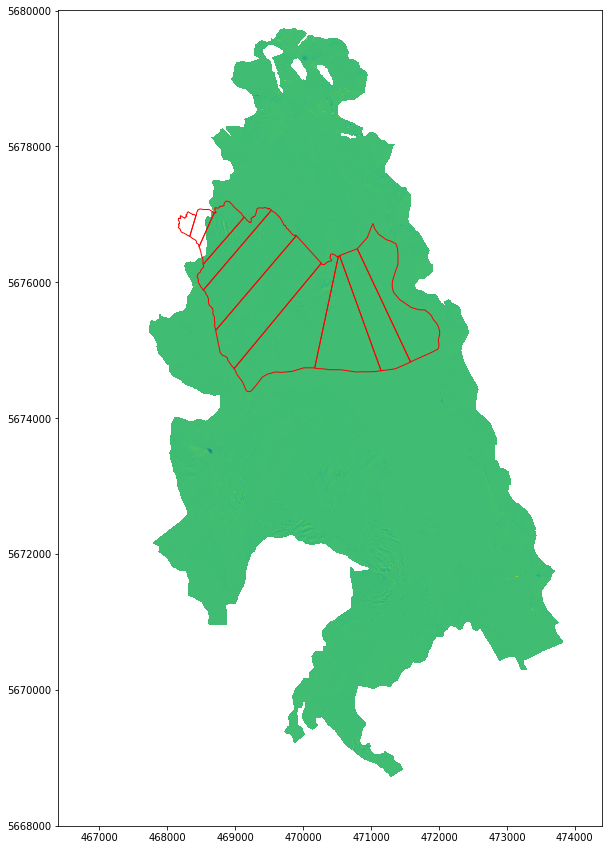

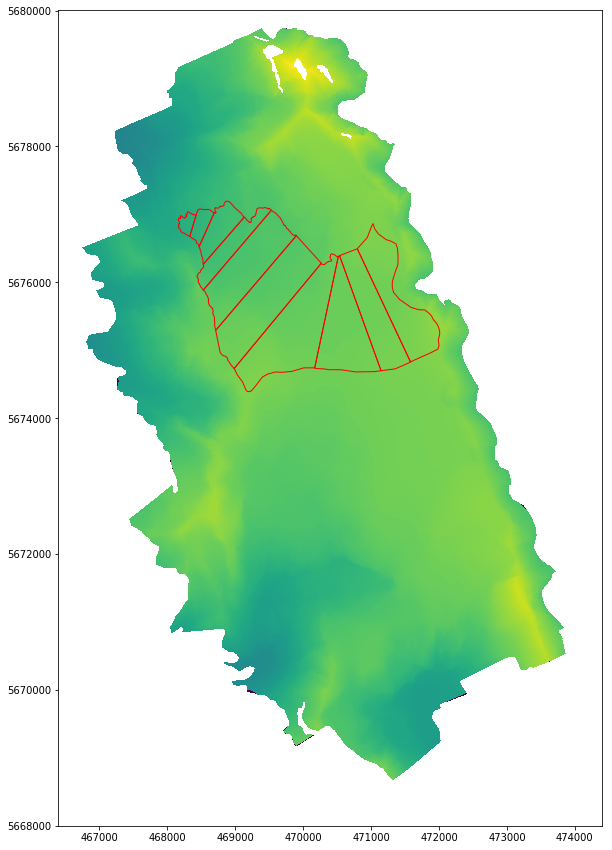

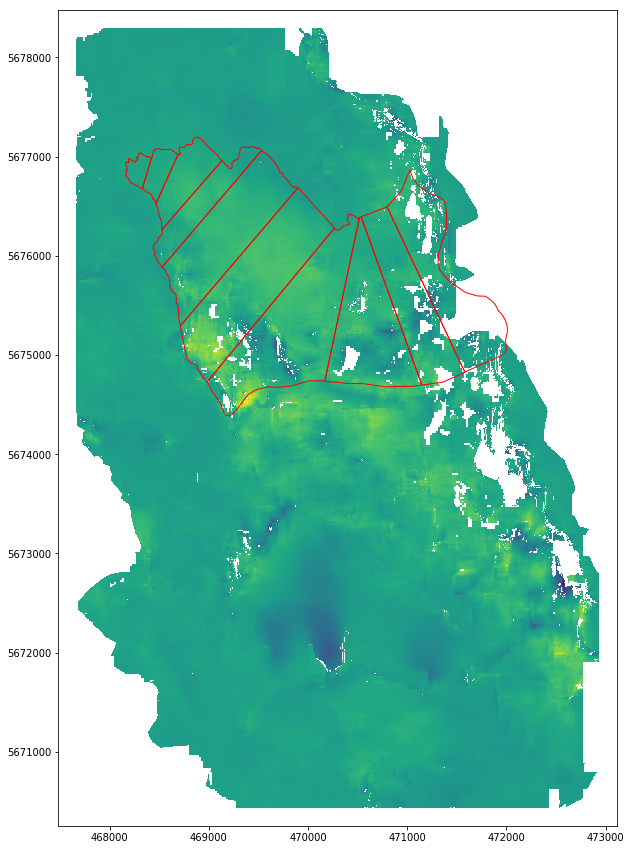

In [15]:
FG_df = FG.copy()
dem_r = topo
vel_r = VY #vdir + vf[:-1] + '-F_vm.tif'
shp = loadshp_as_gpd(bins)

rasters = [dh_r, dem_r, vel_r]
names = ['dh','dem','vy']
for i in range(len(rasters)):
    raster = rasters[i]
    rst = rasterio.open(raster)
    shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
    # dhdt= vx.salem.transform(dhdt)
    name = names[i]
#     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
    stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
    ZS = (get_zonal_stats(shp, raster, stats))
    ZS.drop(['geometry'], axis=1, inplace=True)
    ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
    ZS.sort_values(by=['bin'],ascending=True, inplace=True)
    ZS.set_index('bin', inplace=True)
    FG_df =  pd.concat([FG_df, ZS], axis=1)
    

In [16]:
rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
rho.set_index('bin', inplace=True) # set bin as index for sorting
rho[0:4]
FG_df =  pd.concat([FG_df, rho], axis=1)
FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,dem_std,vy_count,vy_mean,vy_med,vy_std,rho_2016,rho_2017,rho_2018,mean,Vfirn
0,0.000000e+00,1.040149e+05,0.000000,0.000000e+00,2.477464e+04,0.000000e+00,1.071371e+05,0.000000,26334.718202,0.000000,...,24.749604,2258,7.203511,7.165416,1.463638,910,910,910,910.000000,0.000
1,1.040149e+05,3.554363e+05,4793.717285,2.477464e+04,6.926181e+04,1.071371e+05,3.896593e+05,26334.718202,73481.556130,4605.445801,...,24.819602,4137,9.387588,9.234552,2.852916,910,910,910,910.000000,0.000
2,3.554363e+05,1.270572e+06,12703.967773,6.926181e+04,2.721668e+05,3.896593e+05,1.312055e+06,73481.556130,265959.353611,13225.303711,...,32.210658,10586,14.962244,14.105186,6.011854,910,910,910,910.000000,0.000
3,1.270572e+06,2.582387e+06,48849.203125,2.721668e+05,7.185838e+05,1.312055e+06,2.070708e+06,265959.353611,550230.380116,46513.636719,...,30.008066,12809,13.801112,13.718437,9.725754,910,910,910,910.000000,0.000
4,2.582387e+06,4.651327e+06,135301.875000,7.185838e+05,1.067014e+06,2.070708e+06,3.606291e+06,550230.380116,811509.990463,100052.976562,...,41.078025,34500,16.632076,19.645557,9.786743,910,910,910,910.000000,0.000
5,4.651327e+06,3.143059e+06,234394.625000,1.067014e+06,8.526708e+05,3.606291e+06,2.473119e+06,811509.990463,677309.628396,174501.937500,...,54.511542,42506,26.439985,26.872065,14.520864,850,900,890,880.000000,0.000
6,3.143059e+06,6.159668e+05,211227.937500,8.526708e+05,5.019753e+05,2.473119e+06,4.143632e+05,677309.628396,337164.011596,171292.437500,...,50.020876,47050,18.388417,21.292824,16.419312,650,750,725,708.333333,0.049
7,6.159668e+05,1.004118e+05,224668.890625,5.019753e+05,1.537748e+05,4.143632e+05,2.318933e+05,337164.011596,286840.890467,160177.750000,...,18.234675,31689,11.019567,13.063489,13.903852,600,600,600,600.000000,0.235
8,1.004118e+05,2.621525e+05,218781.328125,1.537748e+05,1.817469e+05,2.318933e+05,3.590462e+05,286840.890467,263225.976697,266542.062500,...,20.373179,23551,9.720981,11.033331,12.814424,600,600,600,600.000000,0.357
9,2.621525e+05,0.000000e+00,192972.062500,1.817469e+05,0.000000e+00,3.590462e+05,0.000000e+00,263225.976697,0.000000,251417.078125,...,33.656198,20018,6.758688,7.275897,12.813328,600,650,600,616.666667,0.323


In [17]:
WR= np.array(FG_df.dem_count[1:])
WR= np.append(WR,[0])

FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count

FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count


FG_df['area_Qin']= WR
FG_df['sQoptA'] = FG_df.sQout / FG_df.dem_count
FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)

FG_df['sQoutFA'] = FG_df.sQoutF / FG_df.dem_count
FG_df['sQ_inFA'] = FG_df.sQinF / (FG_df.area_Qin+0.001)
FG_df['sQnetFA'] = np.sqrt(FG_df.sQoutFA**2 + FG_df.sQ_inFA**2)


##calculate height change due to mass balance for highest bins considering firn compaction
FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

# FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
## Ilec slope, constant: (0.025293682808396056, 400.09590745271896)
FG_df['rho_snow'] = (FG_df.dem_mean*(-0.02529))+400.095  #*-0.11255+743.22)
if balance == 'Bw':
#     FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
    FG_df['b_fg_we'] = FG_df.rho_snow/1000 * FG_df.b_fg_h
else:
    FG_df['b_fg_we'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h
       
if balance == 'Bw':
#     FG_df['b_fg_weF'] = rho_snow/1000. * FG_df.b_fg_hF
    FG_df['b_fg_weF'] = FG_df.rho_snow/1000 * FG_df.b_fg_hF
else:
    FG_df['b_fg_weF'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_hF
# FG_df.drop(FG_df.tail(1).index,inplace=True)

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQ_inA,sQnetA_opt,sQoutFA,sQ_inFA,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF
0,0.000000e+00,1.040149e+05,0.000000,0.000000e+00,2.477464e+04,0.000000e+00,1.071371e+05,0.000000,26334.718202,0.000000,...,0.239419,0.239419,0.000000,0.254496,0.254496,NaN,NaN,347.735691,NaN,NaN
1,1.040149e+05,3.554363e+05,4793.717285,2.477464e+04,6.926181e+04,1.071371e+05,3.896593e+05,26334.718202,73481.556130,4605.445801,...,0.261851,0.354807,0.254496,0.277805,0.376754,-4.135025,-4.435580,345.768637,-3.762873,-4.036377
2,3.554363e+05,1.270572e+06,12703.967773,6.926181e+04,2.721668e+05,3.896593e+05,1.312055e+06,73481.556130,265959.353611,13225.303711,...,0.848842,0.888312,0.277805,0.829482,0.874766,-4.337052,-4.364499,343.077873,-3.946718,-3.971694
3,1.270572e+06,2.582387e+06,48849.203125,2.721668e+05,7.185838e+05,1.312055e+06,2.070708e+06,265959.353611,550230.380116,46513.636719,...,0.831649,1.188349,0.829482,0.636806,1.045735,-4.674525,-2.949308,341.277868,-4.253818,-2.683870
4,2.582387e+06,4.651327e+06,135301.875000,7.185838e+05,1.067014e+06,2.070708e+06,3.606291e+06,550230.380116,811509.990463,100052.976562,...,0.976144,1.282380,0.636806,0.742399,0.978100,-2.796206,-2.178928,339.521720,-2.544547,-1.982825
5,4.651327e+06,3.143059e+06,234394.625000,1.067014e+06,8.526708e+05,3.606291e+06,2.473119e+06,811509.990463,677309.628396,174501.937500,...,0.694443,1.197960,0.742399,0.551623,0.924902,1.103521,0.760369,337.385508,0.937993,0.646314
6,3.143059e+06,6.159668e+05,211227.937500,8.526708e+05,5.019753e+05,2.473119e+06,4.143632e+05,677309.628396,337164.011596,171292.437500,...,0.593953,0.913800,0.551623,0.398943,0.680767,2.052055,1.670627,335.677728,1.333836,1.085908
7,6.159668e+05,1.004118e+05,224668.890625,5.019753e+05,1.537748e+05,4.143632e+05,2.318933e+05,337164.011596,286840.890467,160177.750000,...,0.228602,0.636427,0.398943,0.426418,0.583941,0.818263,0.424146,335.509901,0.490958,0.254488
8,1.004118e+05,2.621525e+05,218781.328125,1.537748e+05,1.817469e+05,2.318933e+05,3.590462e+05,286840.890467,263225.976697,266542.062500,...,0.217970,0.315863,0.426418,0.315688,0.530557,0.048225,0.099643,334.835898,0.028935,0.059786
9,2.621525e+05,0.000000e+00,192972.062500,1.817469e+05,0.000000e+00,3.590462e+05,0.000000e+00,263225.976697,0.000000,251417.078125,...,0.000000,0.217970,0.315688,0.000000,0.315688,0.671826,0.788031,333.812194,0.403095,0.472818


In [18]:
### Uncertainties
sDHdt = 0.04 #m Bias dh from Pelto et al. 2019
sVfirn = 0.10
sRHO = 0.05 # percent uncertainty in density

# if FG_df.Vfirn > 0.00:
# FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnet_opt / FG_df.dem_count)**2 + (FG_df.Vfirn*sVfirn)**2) #FG_df.sQnet_opt / FG_df.dem_count
FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_df['sDH_F'] = np.sqrt(sDHdt**2 + (FG_df.sQnetFA)**2 + (FG_df.Vfirn*sVfirn)**2)
FG_df['sBwe_F'] = np.sqrt((FG_df.sDH_F * (FG_df['rho_%s'%year]/1000.))**2+
               (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt,sDH_F,sBwe_F
0,0.000000e+00,1.040149e+05,0.000000,0.000000e+00,2.477464e+04,0.000000e+00,1.071371e+05,0.000000,26334.718202,0.000000,...,0.254496,NaN,NaN,347.735691,NaN,NaN,0.242738,NaN,0.257620,NaN
1,1.040149e+05,3.554363e+05,4793.717285,2.477464e+04,6.926181e+04,1.071371e+05,3.896593e+05,26334.718202,73481.556130,4605.445801,...,0.376754,-4.135025,-4.435580,345.768637,-3.762873,-4.036377,0.357054,0.334056,0.378871,0.353396
2,3.554363e+05,1.270572e+06,12703.967773,6.926181e+04,2.721668e+05,3.896593e+05,1.312055e+06,73481.556130,265959.353611,13225.303711,...,0.874766,-4.337052,-4.364499,343.077873,-3.946718,-3.971694,0.889213,0.810167,0.875680,0.797868
3,1.270572e+06,2.582387e+06,48849.203125,2.721668e+05,7.185838e+05,1.312055e+06,2.070708e+06,265959.353611,550230.380116,46513.636719,...,1.045735,-4.674525,-2.949308,341.277868,-4.253818,-2.683870,1.189022,1.082335,1.046500,0.952685
4,2.582387e+06,4.651327e+06,135301.875000,7.185838e+05,1.067014e+06,2.070708e+06,3.606291e+06,550230.380116,811509.990463,100052.976562,...,0.978100,-2.796206,-2.178928,339.521720,-2.544547,-1.982825,1.283003,1.167676,0.978917,0.891002
5,4.651327e+06,3.143059e+06,234394.625000,1.067014e+06,8.526708e+05,3.606291e+06,2.473119e+06,811509.990463,677309.628396,174501.937500,...,0.924902,1.103521,0.760369,337.385508,0.937993,0.646314,1.198628,1.018901,0.925767,0.786990
6,3.143059e+06,6.159668e+05,211227.937500,8.526708e+05,5.019753e+05,2.473119e+06,4.143632e+05,677309.628396,337164.011596,171292.437500,...,0.680767,2.052055,1.670627,335.677728,1.333836,1.085908,0.914689,0.594550,0.681959,0.443277
7,6.159668e+05,1.004118e+05,224668.890625,5.019753e+05,1.537748e+05,4.143632e+05,2.318933e+05,337164.011596,286840.890467,160177.750000,...,0.583941,0.818263,0.424146,335.509901,0.490958,0.254488,0.638115,0.382870,0.585781,0.351470
8,1.004118e+05,2.621525e+05,218781.328125,1.537748e+05,1.817469e+05,2.318933e+05,3.590462e+05,286840.890467,263225.976697,266542.062500,...,0.530557,0.048225,0.099643,334.835898,0.028935,0.059786,0.320381,0.192239,0.533259,0.319962
9,2.621525e+05,0.000000e+00,192972.062500,1.817469e+05,0.000000e+00,3.590462e+05,0.000000e+00,263225.976697,0.000000,251417.078125,...,0.315688,0.671826,0.788031,333.812194,0.403095,0.472818,0.223951,0.134375,0.319847,0.191911


In [19]:
D['Agpr']=np.NaN
D.sort_values(by=['distance'],ascending=True, inplace=True) 
D = D.dropna(subset=['gpr'])
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] * D.gpr[D.id==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 * D.gpr[D.id==n][c]
        elif c==len(D.id[D.id==n])-2: #
            G= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 * D.gpr[D.id==n]
        elif c==len(D.id[D.id==n])-1:  #last point in line
            G= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] * D.gpr[D.id==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))* D.gpr[D.id==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.id==n] * D.gpr[D.id==n]
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            L= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] 
        elif c==1:
            L= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 
        elif c==len(D.id[D.id==n])-2: #
            L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 
        elif c==len(D.id[D.id==n])-1:  #last point in line
            L= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] 
        else:
            L=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))
       
        D.loc[idx,'Len_gpr']= L

#calculate flux out using GPR thicknesses
sGPR = 0.0516 #gpr error %
D['sInterp_gpr'] = np.nan
for n in range(len(D.Len_gpr)):
    if D.Len_gpr[n] > 50.:
        D.sInterp_gpr[n] = D.gpr[n] * 0.10  
    else: 
        D.sInterp_gpr[n] = 0.0
sH_gpr = np.sqrt(D.sInterp_gpr**2+ (D.gpr*sGPR)**2)
# if vcorr==True:
#     D['Qo_gpr'] = D.Agpr * (D.vfg - off_ice_V+sVZ) * Dint#* 0.9
# else:
D['Qo_gpr'] = D.Agpr * (D.vfg) * Dint#* 0.9
D['sQo_gpr'] =  np.sqrt((sVZ * (D.gpr) * D.Len_gpr)**2 + ((D.vfg*Dint) * D.Len_gpr * (sH_gpr))**2)

# D['sQo_gpr'] = np.sqrt((sVZ**2) * ((D.gpr**2 + (sH_gpr)**2) * (D.vfg*Dint)**2) * d**2)

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [20]:
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,...,Qfarin,a,a_farin,sQout,sQoutF,Agpr,Len_gpr,sInterp_gpr,Qo_gpr,sQo_gpr
ij,,,,,,,,,,,,,,,,,,,,,
0169_0360,0,329.2,0.0,16.530925,-117.453702,51.240545,NaN,NaN,0.000000,6.393974,...,NaN,127.879478,-160.283112,NaN,NaN,20.000000,20.0,0.0,NaN,NaN
0537_0748,6,1684.2,0.0,11.960697,-117.427178,51.223233,-4.874161,9.758244,107.282196,47.509911,...,14641.804413,950.198242,2395.746826,4701.476097,11853.890519,20.000000,20.0,0.0,122.231653,10556.818382
0300_0749,5,2014.5,0.0,39.611641,-117.444168,51.223099,-2.122368,16.444006,0.000000,35.065506,...,1090.108335,701.310120,99.941406,3527.375779,502.674755,240.000000,240.0,0.0,2617.793867,0.000000
0209_0518,3,1546.4,0.0,40.449233,-117.450767,51.233473,NaN,NaN,0.000000,27.092962,...,NaN,541.859253,-201.440430,NaN,NaN,320.000000,320.0,0.0,NaN,NaN
0209_0442,2,918.4,0.0,41.029996,-117.450796,51.236900,-10.686650,5.718801,0.000000,21.113785,...,3603.140208,422.275696,338.825745,2121.445164,1702.206202,20.000000,20.0,0.0,212.683959,0.000000
0197_0390,1,552.9,0.0,24.124671,-117.451711,51.239224,NaN,NaN,0.000000,11.934822,...,NaN,238.696442,111.563187,NaN,NaN,20.000000,20.0,0.0,NaN,NaN
0819_0729,8,1840.0,0.0,334.803597,-117.406983,51.224138,0.000000,0.000000,122.829941,NaN,...,NaN,NaN,3423.974609,NaN,NaN,20.000000,20.0,0.0,NaN,NaN
0212_0439,2,918.4,20.0,41.029996,-117.450609,51.237036,-10.086514,5.999817,39.450001,30.656107,...,3545.747652,613.122131,341.174316,3077.127869,1712.280355,394.500008,10.0,0.0,4099.949523,1948.513771
0538_0744,6,1684.2,20.0,11.960697,-117.427120,51.223409,-1.184674,19.006586,109.937233,47.509911,...,10460.837264,950.198242,2279.991699,4685.797884,11243.526639,1099.372330,10.0,0.0,5044.033932,5404.189237


In [21]:
# D.to_csv(fl_path+'kok_16.csv') #'kokanee_gpr_fluxG_pts.csv')
# for i in range(len(range(D.id.nunique()+1))):
#     print(i, D.Agpr[D.id==i].mean())

In [22]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
sQo_gpr= [0.,]
n=0
for n in range(D.id.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.id==n].sum())
        vzdir_gpr.append(D.vzdir[D.id==n].mean())
        sQo_gpr.append(D.sQo_gpr[D.id==n].sum())
Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
Qin_gpr = np.squeeze(Qin_gpr)
sQin_gpr = [sQo_gpr[1:]+ [0.0]]
sQin_gpr = np.squeeze(sQin_gpr)


In [23]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr, sQo_gpr,sQin_gpr)), 
                      columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr', 'sQo_gpr','sQin_gpr']) 
FG_gpr['bin'] = np.arange(0,len(range(D.id.nunique()+1)),1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)
FG_gpr

,Qo_gpr,Qin_gpr,cr_area_gpr,sQo_gpr,sQin_gpr,bin
0,0.000000e+00,2.114405e+05,0.000000,0.000000,51620.608165,0
1,2.114405e+05,6.212569e+05,10292.571049,51620.608165,127715.547779,1
2,6.212569e+05,1.713083e+06,23286.275787,127715.547779,335670.441976,2
3,1.713083e+06,2.383249e+06,60285.397652,335670.441976,515537.995868,3
4,2.383249e+06,3.634598e+06,100066.940727,515537.995868,735662.420016,4
5,3.634598e+06,3.180304e+06,165065.226688,735662.420016,820070.194488,5
6,3.180304e+06,2.623167e+05,182654.139648,820070.194488,186798.313375,6
7,2.623167e+05,1.394673e+05,260368.561935,186798.313375,202007.479435,7
8,1.394673e+05,3.859076e+05,215495.671387,202007.479435,254691.788476,8
9,3.859076e+05,0.000000e+00,238314.498505,254691.788476,0.000000,9


In [24]:
FG_df

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt,sDH_F,sBwe_F
0,0.000000e+00,1.040149e+05,0.000000,0.000000e+00,2.477464e+04,0.000000e+00,1.071371e+05,0.000000,26334.718202,0.000000,...,0.254496,NaN,NaN,347.735691,NaN,NaN,0.242738,NaN,0.257620,NaN
1,1.040149e+05,3.554363e+05,4793.717285,2.477464e+04,6.926181e+04,1.071371e+05,3.896593e+05,26334.718202,73481.556130,4605.445801,...,0.376754,-4.135025,-4.435580,345.768637,-3.762873,-4.036377,0.357054,0.334056,0.378871,0.353396
2,3.554363e+05,1.270572e+06,12703.967773,6.926181e+04,2.721668e+05,3.896593e+05,1.312055e+06,73481.556130,265959.353611,13225.303711,...,0.874766,-4.337052,-4.364499,343.077873,-3.946718,-3.971694,0.889213,0.810167,0.875680,0.797868
3,1.270572e+06,2.582387e+06,48849.203125,2.721668e+05,7.185838e+05,1.312055e+06,2.070708e+06,265959.353611,550230.380116,46513.636719,...,1.045735,-4.674525,-2.949308,341.277868,-4.253818,-2.683870,1.189022,1.082335,1.046500,0.952685
4,2.582387e+06,4.651327e+06,135301.875000,7.185838e+05,1.067014e+06,2.070708e+06,3.606291e+06,550230.380116,811509.990463,100052.976562,...,0.978100,-2.796206,-2.178928,339.521720,-2.544547,-1.982825,1.283003,1.167676,0.978917,0.891002
5,4.651327e+06,3.143059e+06,234394.625000,1.067014e+06,8.526708e+05,3.606291e+06,2.473119e+06,811509.990463,677309.628396,174501.937500,...,0.924902,1.103521,0.760369,337.385508,0.937993,0.646314,1.198628,1.018901,0.925767,0.786990
6,3.143059e+06,6.159668e+05,211227.937500,8.526708e+05,5.019753e+05,2.473119e+06,4.143632e+05,677309.628396,337164.011596,171292.437500,...,0.680767,2.052055,1.670627,335.677728,1.333836,1.085908,0.914689,0.594550,0.681959,0.443277
7,6.159668e+05,1.004118e+05,224668.890625,5.019753e+05,1.537748e+05,4.143632e+05,2.318933e+05,337164.011596,286840.890467,160177.750000,...,0.583941,0.818263,0.424146,335.509901,0.490958,0.254488,0.638115,0.382870,0.585781,0.351470
8,1.004118e+05,2.621525e+05,218781.328125,1.537748e+05,1.817469e+05,2.318933e+05,3.590462e+05,286840.890467,263225.976697,266542.062500,...,0.530557,0.048225,0.099643,334.835898,0.028935,0.059786,0.320381,0.192239,0.533259,0.319962
9,2.621525e+05,0.000000e+00,192972.062500,1.817469e+05,0.000000e+00,3.590462e+05,0.000000e+00,263225.976697,0.000000,251417.078125,...,0.315688,0.671826,0.788031,333.812194,0.403095,0.472818,0.223951,0.134375,0.319847,0.191911


In [25]:
FG_all = FG_df.merge(FG_gpr, how='left') #on='bin')  
# FG_all
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count 
FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr  #dh1516_mean


FG_all['sQoutA_gpr'] = FG_all.sQo_gpr / FG_all.dem_count
FG_all['sQ_inA_gpr'] = FG_all.sQin_gpr / (FG_all.area_Qin+0.001)
FG_all['sQnetA_gpr'] = np.sqrt(FG_all.sQoutA_gpr**2 + FG_all.sQ_inA_gpr**2)


if balance == 'Bw':
    FG_all['b_fg_we_gpr'] = FG_df.rho_snow/1000. * FG_all.b_fg_h_gpr
else:
    FG_all['b_fg_we_gpr'] = FG_all['rho_%s'%year]/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)

FG_all['sDH_gpr'] = np.sqrt(sDHdt**2 + (FG_all.sQnetA_gpr)**2 + (FG_all.Vfirn*sVfirn)**2)
FG_all['sBwe_gpr'] = np.sqrt((FG_all.sDH_gpr * (FG_all['rho_%s'%year]/1000.))**2+
               (FG_all.dh_mean * (FG_all['rho_%s'%year]/1000.*sRHO))**2)

# FG_all['dem_mean']
FG_all

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,...,sQin_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,sQoutA_gpr,sQ_inA_gpr,sQnetA_gpr,b_fg_we_gpr,sDH_gpr,sBwe_gpr
0,0.000000e+00,1.040149e+05,0.000000,0.000000e+00,2.477464e+04,0.000000e+00,1.071371e+05,0.000000,26334.718202,0.000000,...,51620.608165,2.114405e+05,3.739464,NaN,0.000000,0.498856,0.498856,NaN,0.500457,NaN
1,1.040149e+05,3.554363e+05,4793.717285,2.477464e+04,6.926181e+04,1.071371e+05,3.896593e+05,26334.718202,73481.556130,4605.445801,...,127715.547779,4.098163e+05,3.960420,-5.665736,0.498856,0.482842,0.694258,-5.155820,0.695409,0.637561
2,3.554363e+05,1.270572e+06,12703.967773,6.926181e+04,2.721668e+05,3.896593e+05,1.312055e+06,73481.556130,265959.353611,13225.303711,...,335670.441976,1.091826e+06,4.127762,-5.005049,0.482842,1.046899,1.152881,-4.554594,1.153575,1.050512
3,1.270572e+06,2.582387e+06,48849.203125,2.721668e+05,7.185838e+05,1.312055e+06,2.070708e+06,265959.353611,550230.380116,46513.636719,...,515537.995868,6.701659e+05,2.090134,-2.673330,1.046899,0.596655,1.204988,-2.432730,1.205651,1.097464
4,2.582387e+06,4.651327e+06,135301.875000,7.185838e+05,1.067014e+06,2.070708e+06,3.606291e+06,550230.380116,811509.990463,100052.976562,...,735662.420016,1.251349e+06,1.448242,-1.849972,0.596655,0.673011,0.899412,-1.683474,0.900301,0.819477
5,4.651327e+06,3.143059e+06,234394.625000,1.067014e+06,8.526708e+05,3.606291e+06,2.473119e+06,811509.990463,677309.628396,174501.937500,...,820070.194488,-4.542945e+05,-0.415605,0.139306,0.673011,0.667892,0.948168,0.118411,0.949012,0.806745
6,3.143059e+06,6.159668e+05,211227.937500,8.526708e+05,5.019753e+05,2.473119e+06,4.143632e+05,677309.628396,337164.011596,171292.437500,...,186798.313375,-2.917987e+06,-2.376503,2.321413,0.667892,0.221026,0.703514,1.508918,0.704667,0.458037
7,6.159668e+05,1.004118e+05,224668.890625,5.019753e+05,1.537748e+05,4.143632e+05,2.318933e+05,337164.011596,286840.890467,160177.750000,...,202007.479435,-1.228494e+05,-0.145359,0.118601,0.221026,0.300304,0.372874,0.071161,0.375749,0.225451
8,1.004118e+05,2.621525e+05,218781.328125,1.537748e+05,1.817469e+05,2.318933e+05,3.590462e+05,286840.890467,263225.976697,266542.062500,...,254691.788476,2.464403e+05,0.366358,-0.434690,0.300304,0.305452,0.428350,-0.260814,0.431692,0.259024
9,2.621525e+05,0.000000e+00,192972.062500,1.817469e+05,0.000000e+00,3.590462e+05,0.000000e+00,263225.976697,0.000000,251417.078125,...,0.000000,-3.859076e+05,-0.462820,0.497245,0.305452,0.000000,0.305452,0.298347,0.309749,0.185852


## Plot balance gradients

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


slope RLM: 0.01585661356748184
slope RLM: 0.013260960148405599
slope RLM: 0.012547655400876413
slope RLM: 0.011758420091993658


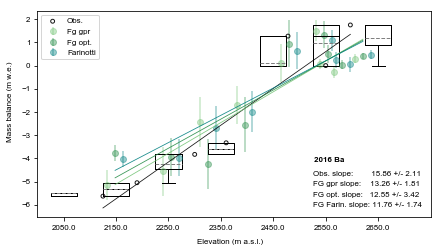

In [26]:
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.9
color=['b', 'lime', 'green', 'teal']

##all_obs
if balance == 'Bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw

else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba


x_ax_obs=obs[(obs.Year==year)].Elev
##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs


# ### countour SMB
# Ba_contour = pd.read_

# Drop unrealistic FG smb:
new = FG_all.copy()

new = new[new.b_fg_we >-8.]
new = new[new.b_fg_we_gpr >-8.]

#errors (above and below)
# new['yerr'] = 0.20
yerr = [0.0, new.sBwe_gpr , new.sBwe_opt, new.sBwe_F] #new.sBwe_gpr
new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
xerr = new.xerr 

 
x_ax_fg_gpr=new.dem_mean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we
x_ax_fg_F=new.dem_mean  
y_ax_fg_F=new.b_fg_weF



x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]
color = ['k', 'teal', '#74c476', '#238b45', ]
label = ['Obs.', 'Fg gpr', 'Fg opt.','Farinotti']

# Call function to create error bars 
shift = [-15,0,15]
for i in range(3):
    ax.errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1], fmt='o', ecolor=color[i+1], zorder=2,
                          label=label[i+1], alpha=0.4, c=color[i+1]) #elinewidth=0.7
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])  #[0]
#     _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, hue=color[i+1])[1]
    
## create range bar to represent flux gate elevation range
# theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
#                           elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

## plot data and regression lines
ax.scatter(x[0],y[0],color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3)  ##plot obs data
color2 = ['b', 'y', 'purple', 'orange']
ytxt = [0.2, 0.15, 0.1, 0.05]
for i in range(4):
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
#     ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
    
#     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
#     ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='Lin', alpha=a, linewidth=0.9, zorder=3)
#     print(slope, intercept, r_value, p_value, std_err)
    txt= ['Obs. slope:        ', 'FG gpr slope:    ', 'FG opt. slope:   ', 'FG Farin. slope: ']
           
#     'H_{opt}''slope:$'

    #################### RLM  https://www.statsmodels.org/stable/rlm.html
    ###https://www.statsmodels.org/devel/generated/statsmodels.robust.robust_linear_model.RLMResults.html
    exog = stm.add_constant(x[i]) #obs_data.Elev)
    rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
    rlm_results = rlm_model.fit()
    stdE=rlm_results.bse[1]
    # print(rlm_results.params)
     # ax.scatter(x[i],y[i],color=color[i], label='data', alpha=a, s=s,facecolor='', zorder=3)
    #     ax = sns.boxplot(x=x[i], y=y[i], palette='copper', saturation=0.7)#, ax=ax)
    ax.plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
            linewidth=0.8, zorder=3) # linestyle='--'
    print('slope RLM:', rlm_results.params[1])
    #############################
    ax.text(0.7, ytxt[i], txt[i]+str(np.round(1000*rlm_results.params[1],2))+ ' +/- ' + 
            str(np.round(1000*stdE,2)), transform=ax.transAxes)
    
if balance == 'ba':
    ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)
    
############ obs data box plot ################
obs_data=obs[(obs.Year==year)]
obs_data.reset_index(inplace=True)

bin_size = 100.
z_range = np.arange(1950., 2750., bin_size)
# print(z_range)
# obs_data['Elev_bin'] = np.nan

i = 0
# for n in range(len(obs_data.Ba)):

Z_F = []
Zor_F= []
OB_F=[]

for z in z_range: 
    OBS = []
    Z = []
    Zor = []
    W=0
    bin_size = 100.
    while W==0:
        for n in range(len(obs_data[balance])):
            if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                O = obs_data[balance][n]
                Z.append(z)
                Zor.append(obs_data.Elev[n])
                OBS.append(O)
                
        if len(OBS)<3:
            ##could select last element below elevation
            bin_size=bin_size*1.5
        else:
            OB_F.append(np.array(OBS))
            Z_F.append(np.array(Z))
            Zor_F.append(np.array(Zor))
            
            W=1
    i += 1


meanlineprops = dict(linestyle='--', linewidth=1., color='0.5')
medianprops = dict(linestyle='-', linewidth=1, color='k')
BOX=plt.boxplot(OB_F[1:],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                positions=[2050., 2150., 2250., 2350., 2450., 2550., 2650.,],widths=50)
#                            2050., 2150., 2250., 2350., 2450., 2550., 2650., 2750.
# Add jitter with the swarmplot function.
# ax = sns.swarmplot(x=Zor, y=OBS, color="grey")
# glacio = [Z, OBS]

# ax.boxplot(glacio)

############################
ax.set_xlim(2000,2750)
fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.08, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
fig.text(0.72, 0.35, str(year)+ ' '+ balance, fontweight='bold')
plt.savefig(fl_path + 'products/' + Glacier[gl]+'_bdot_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

In [27]:
bin_size = 100.
z_range = np.arange(2050., 2850., bin_size)
z_range

array([2050., 2150., 2250., 2350., 2450., 2550., 2650., 2750.])

In [28]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()
print(B_opt)
print(B_gpr)


-0.2509579004311853
-0.2983389786267963


## Plot flux gates as cross-sections

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


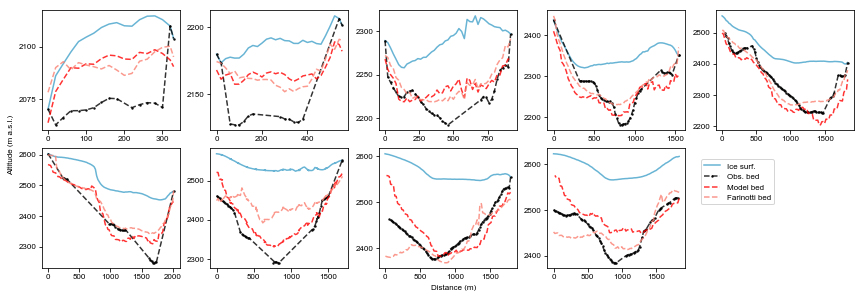

In [29]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs_H = df_agg.copy()
obs_H = obs_H.dropna(subset=['gpr']) #, inplace=True)   

fig, ax = plt.subplots(2,5, figsize=(12,4))
for i in range(D.id.nunique()):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs_H[obs_H.id==i].dem)-(obs_H[obs_H.id==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(obs_H[obs_H.id==i].distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ##plot Farinotti thickness gates
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].farin_corr), 
                 ls='--', c='salmon', alpha=a, label='Farinotti bed')  #marker='o')
    ax[1,4].axis('off')
    if i == 0:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(25))
    elif i <= 2:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50))
    else:
        ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100))
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 5: 
        j += 1
        k = 0  
         
    ax[0,4].legend(loc=4,  bbox_to_anchor=(0.45, -0.65),)
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.05, right=0.99, wspace=0.22, hspace=0.15) 

plt.savefig(fl_path + 'products/' + glacier[gl]+'_flux_gates.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

In [30]:
pd.set_option('display.max_columns', None)
new

,Q_out,Q_in,cr_area,sQout,sQin,Q_outF,Q_inF,sQoutF,sQinF,cr_areaF,vzdir,vfg,vfgF,bin,dh_count,dh_mean,dh_med,dh_std,dem_count,dem_mean,dem_med,dem_std,vy_count,vy_mean,vy_med,vy_std,rho_2016,rho_2017,rho_2018,mean,Vfirn,Q_net,Q_netA,Q_netF,Q_netAF,area_Qin,sQoptA,sQ_inA,sQnetA_opt,sQoutFA,sQ_inFA,sQnetFA,b_fg_h,b_fg_hF,rho_snow,b_fg_we,b_fg_weF,sDH_opt,sBwe_opt,sDH_F,sBwe_F,Qo_gpr,Qin_gpr,cr_area_gpr,sQo_gpr,sQin_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,sQoutA_gpr,sQ_inA_gpr,sQnetA_gpr,b_fg_we_gpr,sDH_gpr,sBwe_gpr,xerr,FG_opt_m3_we,FG_gpr_m3_we
1,1.040149e+05,3.554363e+05,4793.717285,2.477464e+04,6.926181e+04,1.071371e+05,3.896593e+05,26334.718202,73481.556130,4605.445801,-66.321030,21.698162,22.349482,1,12083,-1.705316,-1.809814,1.080233,103478,2148.136145,2147.823730,24.819602,4137,9.387588,9.234552,2.852916,910,910,910,910.000000,0.000,2.514215e+05,2.429709,2.825222e+05,2.730264,264508,0.239419,0.261851,0.354807,0.254496,0.277805,0.376754,-4.135025,-4.435580,345.768637,-3.762873,-4.036377,0.357054,0.334056,0.378871,0.353396,2.114405e+05,6.212569e+05,10292.571049,51620.608165,127715.547779,4.098163e+05,3.960420,-5.665736,0.498856,0.482842,0.694258,-5.155820,0.695409,0.637561,37.229403,-3.893746e+05,-5.335139e+05
2,3.554363e+05,1.270572e+06,12703.967773,6.926181e+04,2.721668e+05,3.896593e+05,1.312055e+06,73481.556130,265959.353611,13225.303711,-63.222424,27.978370,30.672254,2,237529,-0.877287,-0.965820,3.230785,264508,2254.532521,2255.872070,32.210658,10586,14.962244,14.105186,6.011854,910,910,910,910.000000,0.000,9.151355e+05,3.459765,9.223954e+05,3.487212,320633,0.261851,0.848842,0.888312,0.277805,0.829482,0.874766,-4.337052,-4.364499,343.077873,-3.946718,-3.971694,0.889213,0.810167,0.875680,0.797868,6.212569e+05,1.713083e+06,23286.275787,127715.547779,335670.441976,1.091826e+06,4.127762,-5.005049,0.482842,1.046899,1.152881,-4.554594,1.153575,1.050512,48.315987,-1.043938e+06,-1.204727e+06
3,1.270572e+06,2.582387e+06,48849.203125,2.721668e+05,7.185838e+05,1.312055e+06,2.070708e+06,265959.353611,550230.380116,46513.636719,-51.172241,26.010084,26.859287,3,320633,-0.583196,-0.753174,1.762315,320633,2325.707061,2322.538086,30.008066,12809,13.801112,13.718437,9.725754,910,910,910,910.000000,0.000,1.311815e+06,4.091329,7.586536e+05,2.366112,864047,0.848842,0.831649,1.188349,0.829482,0.636806,1.045735,-4.674525,-2.949308,341.277868,-4.253818,-2.683870,1.189022,1.082335,1.046500,0.952685,1.713083e+06,2.383249e+06,60285.397652,335670.441976,515537.995868,6.701659e+05,2.090134,-2.673330,1.046899,0.596655,1.204988,-2.432730,1.205651,1.097464,45.012100,-1.363914e+06,-7.800136e+05
4,2.582387e+06,4.651327e+06,135301.875000,7.185838e+05,1.067014e+06,2.070708e+06,3.606291e+06,550230.380116,811509.990463,100052.976562,-49.497883,19.086114,15.304358,4,864047,-0.401730,-0.429443,0.919341,864047,2395.147486,2390.635742,41.078025,34500,16.632076,19.645557,9.786743,910,910,910,910.000000,0.000,2.068940e+06,2.394476,1.535583e+06,1.777199,1093091,0.831649,0.976144,1.282380,0.636806,0.742399,0.978100,-2.796206,-2.178928,339.521720,-2.544547,-1.982825,1.283003,1.167676,0.978917,0.891002,2.383249e+06,3.634598e+06,100066.940727,515537.995868,735662.420016,1.251349e+06,1.448242,-1.849972,0.596655,0.673011,0.899412,-1.683474,0.900301,0.819477,61.617038,-2.198608e+06,-1.454601e+06
5,4.651327e+06,3.143059e+06,234394.625000,1.067014e+06,8.526708e+05,3.606291e+06,2.473119e+06,811509.990463,677309.628396,174501.937500,-32.949154,19.844000,15.385555,5,1093091,-0.276299,-0.276367,0.619729,1093091,2479.616134,2460.371582,54.511542,42506,26.439985,26.872065,14.520864,850,900,890,880.000000,0.000,-1.508268e+06,-1.379819,-1.133172e+06,-1.036668,1227849,0.976144,0.694443,1.197960,0.742399,0.551623,0.924902,1.103521,0.760369,337.385508,0.937993,0.646314,1.198628,1.018901,0.925767,0.786990,3.634598e+06,3.180304e+06,165065.226688,735662.420016,820070.194488,-4.542945e+05,-0.415605,0.139306,0.673011,0.667892,0.948168,0.118411,0.949012,0.806745,81.767313,1.025311e+06,1.294335